In [49]:
import scanpy as sc
import pandas as pd
import numpy as np
import pathlib

import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '..')
from ggml.plot import plot_heatmap, hier_clustering, plot_emb, plot_ellipses
from tqdm import tqdm

(129, 2)
(159, 2)
(102, 2)
(309, 2)
(195, 2)
(63, 2)
(423, 2)
(513, 2)
(372, 2)
(582, 2)
(381, 2)
(234, 2)
(342, 2)
(570, 2)
(525, 2)
(573, 2)
(396, 2)
(354, 2)
(234, 2)
(420, 2)
(279, 2)
(360, 2)
(240, 2)
(339, 2)
(255, 2)
(597, 2)
(546, 2)
(126, 2)
(342, 2)
(231, 2)
             x             y  class  sample
0    12.924735  12792.110682      1       1
1    14.792078  11397.176714      1       1
2    16.742964  14847.657361      1       1
3    10.903411  14726.721038      1       1
4    14.411502  10892.535063      1       1
..         ...           ...    ...     ...
226  41.666343  49686.511421      3      10
227  39.435586  50845.297413      3      10
228  39.985626  49071.803159      3      10
229  39.540035  51976.584351      3      10
230  40.892187  49610.250667      3      10

[10191 rows x 4 columns]


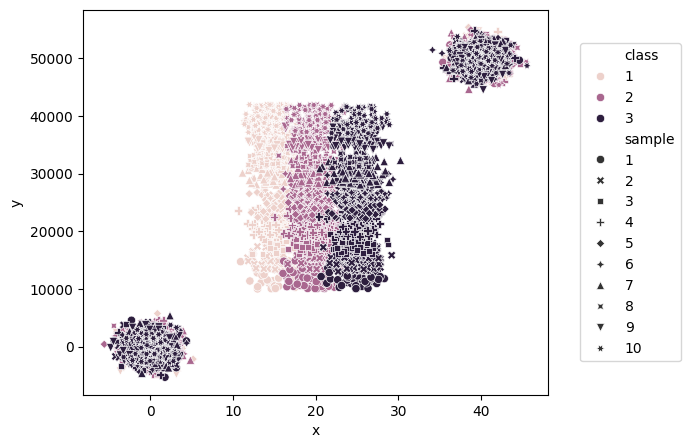

In [50]:
#Gaussian along dim 1, uniform along dim 2 (only information is the mean of the gaussian)

n = 200
means = [5,10,15]
label =[0,1,2]
offsets = 10+ np.arange(0,30,3)

shared_means_x = [0, 40]
shared_means_y = [0, 50]

dists = []
labels = []
dfList =[]
dfList_projected = []


#learend mahalanobis projeciton
W =[[1,0],[0,0]]


for mean,l in zip(means,label):
    i = 0
    for offset in offsets:
        rand_size=np.random.randint(20,n)
        dim1 = np.random.normal(10+mean,size=rand_size,scale=1.5)
        dim2 = np.random.uniform(offset,5+offset,size=rand_size)

        for shared_mean_x,shared_mean_y in zip(shared_means_x,shared_means_y):
            dim1 = np.concatenate((dim1,np.random.normal(shared_mean_x,size=rand_size,scale=1.5)))
            dim2 = np.concatenate((dim2,np.random.normal(shared_mean_y,size=rand_size,scale=1.5))) # #np.random.normal(2.5+offset,size=n)

        dim2 = dim2 * 1000 #scale y
        stacked = np.stack((dim1,dim2),axis=-1)
        dfList.append(pd.DataFrame({'x':dim1,'y':dim2,'class':l+1,'sample':i+1}))
        #print(dfList[-1])


        
  
        #stacked_projected = np.dot(W,stacked.transpose()).transpose()
        #stacked_projected = lmnn.transform(stacked)

        #dfList_projected.append(pd.DataFrame({'x':stacked_projected[:,0],'y':stacked_projected[:,1],'class':l,'sample':i}))

        dists.append(stacked)
        print(stacked.shape)
        labels.append(l)
        i+=1

#dfs = [df.set_index('id') for df in dfList]
from functools import reduce
#df = reduce(lambda x, y: pd.merge(x, y, on=["x","y","class","i"]), dfList)
df = pd.concat(dfList, axis=0)
print(df)

plt.figure(figsize=(6,5))
ax = sns.scatterplot(df,x='x',y='y',hue="class",style='sample')
sns.move_legend(ax, "center right", bbox_to_anchor=(1.3, 0.5))


flat_dists = np.concatenate(dists) #np.reshape(np.asarray(dists),(-1,2))
flat_labels = sum([[l] * len(D) for l,D in zip(labels,dists)],[]) #flattens list of lists

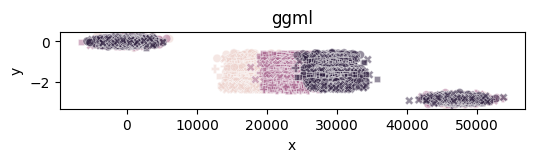

In [51]:
def projection_plot(dists,labels,p,title=""):
    i=0
    dfList_projected = []
    for dist, l in zip(dists,labels):
        stacked_projected = p(dist) 
        dfList_projected.append(pd.DataFrame({'x':stacked_projected[:,0],'y':stacked_projected[:,1],'class':l,'dist':i % 4})) #TODO ahrdcoded
        i += 1

    df_projected= pd.concat(dfList_projected, axis=0)
    plt.figure(figsize=(6,1))
    ax = sns.scatterplot(df_projected,x='x',y='y',hue="class",style='dist',alpha=0.5)
    
    #ax.set_ylim(-0.01, 0.01)

    sns.move_legend(ax, "center right", bbox_to_anchor=(1.3, 0.5))
    ax.get_legend().remove()

    ax.set_title(title)

W = np.asarray([[1177.7152,   0.0030272],
        [  0.0002975, -0.00005729]])


#ggml= lambda d: np.dot(W,d.transpose()).transpose()

ggml= lambda d: np.dot(W,d.transpose()).transpose()
projection_plot(dists,labels,ggml,title="ggml")


In [4]:

'''
def compute_loss(theta,distributions,labels,alpha=0.1,num_iter=1000,temp=0.01,threshold=0.01,lambda_=0.001):
    triplets = []
    for i,_ in enumerate(distributions):
        for j,_ in enumerate(distributions):
            for k,_ in enumerate(distributions):
                if labels[i]==labels[j] and labels[j] != labels[k] and i != j:
                    triplets.append((i,j,k))

    losses = []
    for (i,j,k) in tqdm(triplets):
        dist_ij = compute_dists(distributions[i],distributions[j],theta)
        pi_ij = ot.emd([],[],M=dist_ij,log=False)

        dist_jk = compute_dists(distributions[j],distributions[k],theta)
        pi_jk = ot.emd([],[],M=dist_jk,log=False)
        loss = np.sum(np.multiply(dist_ij,pi_ij) - alpha * np.multiply(dist_jk,pi_jk)) + lambda_ * np.linalg.norm(theta,ord=1) #min 
        losses.append(loss)

    return np.asarray(losses)

n = 100
test_thetas = [np.asarray([[1,0],[0,1]]),np.asarray([[1,0],[0,0]])] + [np.random.uniform(-1,1,(2,2)) for _ in range(n)]
global_losses = []
for test_theta in test_thetas:
    print(test_theta)
    if test_theta[0,0] < 0:
        test_theta = -1 * test_theta
        
    losses= compute_loss(test_theta,dists,labels,alpha=1.0,num_iter=30,temp=0.1,lambda_=0.00001)
    print(f"loss mean {np.average(losses)} min {np.min(losses)} max {np.max(losses)}")
    global_losses.append(losses)

'''
    

'\ndef compute_loss(theta,distributions,labels,alpha=0.1,num_iter=1000,temp=0.01,threshold=0.01,lambda_=0.001):\n    triplets = []\n    for i,_ in enumerate(distributions):\n        for j,_ in enumerate(distributions):\n            for k,_ in enumerate(distributions):\n                if labels[i]==labels[j] and labels[j] != labels[k] and i != j:\n                    triplets.append((i,j,k))\n\n    losses = []\n    for (i,j,k) in tqdm(triplets):\n        dist_ij = compute_dists(distributions[i],distributions[j],theta)\n        pi_ij = ot.emd([],[],M=dist_ij,log=False)\n\n        dist_jk = compute_dists(distributions[j],distributions[k],theta)\n        pi_jk = ot.emd([],[],M=dist_jk,log=False)\n        loss = np.sum(np.multiply(dist_ij,pi_ij) - alpha * np.multiply(dist_jk,pi_jk)) + lambda_ * np.linalg.norm(theta,ord=1) #min \n        losses.append(loss)\n\n    return np.asarray(losses)\n\nn = 100\ntest_thetas = [np.asarray([[1,0],[0,1]]),np.asarray([[1,0],[0,0]])] + [np.random.uniform(-

[(0, 1, 8), (0, 1, 9), (0, 1, 10), (0, 1, 11), (0, 1, 12), (0, 1, 13), (0, 1, 14), (0, 1, 15), (0, 1, 16), (0, 1, 17), (0, 1, 18), (0, 1, 19), (0, 1, 20), (0, 1, 21), (0, 1, 22), (0, 1, 23), (0, 2, 8), (0, 2, 9), (0, 2, 10), (0, 2, 11), (0, 2, 12), (0, 2, 13), (0, 2, 14), (0, 2, 15), (0, 2, 16), (0, 2, 17), (0, 2, 18), (0, 2, 19), (0, 2, 20), (0, 2, 21), (0, 2, 22), (0, 2, 23), (0, 3, 8), (0, 3, 9), (0, 3, 10), (0, 3, 11), (0, 3, 12), (0, 3, 13), (0, 3, 14), (0, 3, 15), (0, 3, 16), (0, 3, 17), (0, 3, 18), (0, 3, 19), (0, 3, 20), (0, 3, 21), (0, 3, 22), (0, 3, 23), (0, 4, 8), (0, 4, 9), (0, 4, 10), (0, 4, 11), (0, 4, 12), (0, 4, 13), (0, 4, 14), (0, 4, 15), (0, 4, 16), (0, 4, 17), (0, 4, 18), (0, 4, 19), (0, 4, 20), (0, 4, 21), (0, 4, 22), (0, 4, 23), (0, 5, 8), (0, 5, 9), (0, 5, 10), (0, 5, 11), (0, 5, 12), (0, 5, 13), (0, 5, 14), (0, 5, 15), (0, 5, 16), (0, 5, 17), (0, 5, 18), (0, 5, 19), (0, 5, 20), (0, 5, 21), (0, 5, 22), (0, 5, 23), (0, 6, 8), (0, 6, 9), (0, 6, 10), (0, 6, 11), (0,

  1%|          | 14/2688 [01:23<4:26:11,  5.97s/it]


KeyboardInterrupt: 

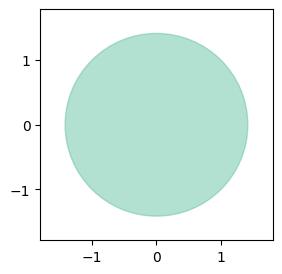

In [5]:
import ot
from scipy.spatial import distance#
compute_gradient = True
approx_gradient = False


def compute_dists(A,B,theta):
    D = np.zeros((len(A),len(B)))
    for i,x in enumerate(A):
        for j,y in enumerate(B):
            #if i<=j:
                #assert isPD(theta), "Theta(k) is not positive semi-definite. This should not have happened as this function is safeguarded..."
                #D[i,j] = distance.mahalanobis(x,y,np.dot(theta,np.transpose(theta))) 
                #print(f"Mahala: {D[i,j]}")
                #print(np.dot(theta,x).shape))
            D[i,j] = np.linalg.norm(np.squeeze(np.dot(theta,x))-np.squeeze((np.dot(theta,y)))) 
                #print(f"2-Norm in Projected Space: {D[i,j]}")
                
            #else:
            #    D[i,j] = D[j,i]
    return D

def logistic(x):
    logi = 2/(1+np.exp(-x)) - 1
    if logi <0:
        logi = 0.1 * logi
    print(f"logistic {logi}")
    return logi

def mahalanobis_distance(W,x1,x2):
    return np.linalg.norm(np.squeeze(np.dot(W,x1))-np.squeeze((np.dot(W,x2)))) 

def get_loss(W,X_i,X_j,X_k,Pi_ij,Pi_jk,alpha):
    dist_ij = compute_dists(X_i,X_j,W)
    dist_jk = compute_dists(X_j,X_k,W)

    return np.sum(np.multiply(dist_ij,Pi_ij)) - alpha *  np.sum(np.multiply(dist_jk,Pi_jk))


def partial_mahalanobis_gradient(W,a,b,x1,x2,lambda_, dia_only=True ):
    if dia_only and a != b:
        return 0
    sqrt_gradient_factor = 1 / 2 * mahalanobis_distance(W,x1,x2) 
    sum_sqr_gradient_factor = 2 * (np.dot(W[a,:],x1) - np.dot(W[a,:],x2))
    inner_gradient_factor = (x1[b]-x2[b])
    return sqrt_gradient_factor * sum_sqr_gradient_factor * inner_gradient_factor + lambda_  * 2 * W[a,b]


def get_loss_jacobian(W,x1,x2,alpha,lambda_ ):
    n = len(W)
    J = np.zeros((n,n))
    for a in range(n):
        for b in range(n):
            J[a,b]=partial_mahalanobis_gradient(W,a,b,x1,x2,lambda_ )
    return J

def total_loss_jacobian(W,X_i,X_j,X_k,Pi_ij,Pi_jk,alpha,lambda_ ):
    J12 = np.zeros(W.shape)
    J23 = np.zeros(W.shape)

    if get_loss(W,X_i,X_j,X_k,Pi_ij,Pi_jk,alpha) > 0:

        for i,xi in enumerate(X_i):
            for j,xj in enumerate(X_j):
                J12 += get_loss_jacobian(W,xi,xj,alpha,lambda_ ) * Pi_ij[i,j]


        for j,xj in enumerate(X_j):
            for k,xk in enumerate(X_k):
                J23 += get_loss_jacobian(W,xj,xk,alpha,lambda_ ) * Pi_jk[j,k]

    return J12 - alpha*J23

    


def gg_ml(distributions,labels,alpha=0.1,num_iter=1000,temp=0.01,threshold=0.01,lambda_=0.001):

    #create tripplets
    triplets = []
    for i,_ in enumerate(distributions):
        for j,_ in enumerate(distributions):
            for k,_ in enumerate(distributions):
                if labels[i]==labels[j] and labels[j] != labels[k] and i != j:
                    triplets.append((i,j,k))
    print(triplets)

    #init distance
    dims_n = distributions[0].shape[-1]
    #theta = np.random.uniform(-1,1,size=(dims_n,dims_n)) 
    #theta = np.diag(np.random.uniform(-1,1,size=(dims_n))) 
    global theta 
    theta = np.asarray([[1,0],[0,1]],dtype="f") #np.identity(dims_n)

    #plot_ellipses(theta)
    plot_ellipses(np.dot(theta,np.transpose(theta)))

    ##theta= np.tril(theta) + np.triu(theta.T, 1)  #enforce symetric
    ##theta = nearestPD(theta) #enforce positive semidefinit
    last_losses = []
    last_loss= None
    

    for s in range(num_iter):
        losses = []
        losses_diff = []
        losses_new=[]
 
        #Random direction for params

        #x, y = np.random.randint(0,dims_n,size=(2))

        #new_val = np.random.uniform()

        #theta_new[x,y] = new_val
        step_size = np.exp(-2*s/num_iter)

        #theta_new = np.copy(theta) + np.random.normal(0,1,size=theta.shape)

        random_direction = np.diag(np.random.uniform(-np.random.normal(0,step_size,size=(dims_n)))) 
        ##mask = np.random.uniform(0,1,size=theta.shape)<2/3
        ##theta_new[mask] = theta[mask]  #50% chance to change a entry in the params or set change to 0

        ##theta_new= np.tril(theta_new) + np.triu(theta_new.T, 1)

        ##theta_new = np.dot(theta_new,theta_new.transpose()) #to enforce theta_new is positive semi-definite (for mahalanobis norm)

        ##if not isPD(theta_new):
        ##    theta_new = nearestPD(theta_new)
            
        ###print("Theta update:")
        ###print(np.dot(theta_new-theta,np.transpose(theta_new-theta)))

        gradient_theta = np.zeros(theta.shape)
        
        for (i,j,k) in tqdm(triplets):
            if np.random.random() < 1/2:

                continue #only compute 1/3 of dataset in each iteration
     
            #Compute optimal transport plan for fixed metric
            #d = lambda x,y: distance.mahalanobis(x,y,theta)

            ##assert isPD(theta_new), "Theta(k-1) is not positive semi-definite"
            dist_ij = compute_dists(distributions[i],distributions[j],theta)
            pi_ij = ot.emd([],[],M=dist_ij,log=False)

            dist_jk = compute_dists(distributions[j],distributions[k],theta)
            pi_jk = ot.emd([],[],M=dist_jk,log=False)

            loss = np.max([np.sum(np.multiply(dist_ij,pi_ij)) - np.sum(alpha * np.multiply(dist_jk,pi_jk)) + lambda_ * np.square(np.linalg.norm(np.dot(theta,theta.transpose()))),0]) #min 

            if compute_gradient:
                gradient_theta += total_loss_jacobian(W=theta,X_i=distributions[i],X_j=distributions[j],X_k=distributions[k],Pi_ij=pi_ij,Pi_jk=pi_jk,alpha=alpha,lambda_ =lambda_ )
        
            

            #d_new = lambda x,y: distance.mahalanobis(x,y,theta_new)
            ##assert isPD(theta_new), "Theta(k) is not positive semi-definite"
            elif approx_gradient:
                dist_ij_new = compute_dists(distributions[i],distributions[j],theta+random_direction)
                pi_ij_new = ot.emd([],[],M=dist_ij_new,log=False)
                dist_jk_new = compute_dists(distributions[j],distributions[k],theta+random_direction)
                pi_jk_new = ot.emd([],[],M=dist_jk_new,log=False)

                

                #loss_jacobian = get_loss_jacobian(W=theta,x1,x2,x3,alpha)
        
                #print(loss)
                loss_new = np.sum(np.multiply(dist_ij_new,pi_ij_new)) - np.sum(alpha *  np.multiply(dist_jk_new,pi_jk_new)) + lambda_ * np.linalg.norm(np.dot(theta+random_direction,(theta+random_direction).transpose()),ord=1)#min
      
            #print(dist_ij_new)
            #print(dist_jk_new)
           
                loss_diff = loss - loss_new 

                losses_new.append(loss_new)
                losses_diff.append(loss_diff)
            #print(loss_diff)
            #print(f"loss diff {loss_diff}")

            
            #theta[theta<0]=0 #TODO solve that inverse cov can't contain zeros but we have not modeled bounds
            
            losses.append(loss)
            
            #print(f"Triplet ({i,j,k}) loss: {loss} loss_diff: {loss_diff}")

        print("Theta:")
        print(theta)


        #theta_update_scale = logistic(np.quantile(losses_diff,q=0.8)) * t

        ##theta_update_scale = logistic(np.average(losses_diff)) * temp
        #replaced by logistic
        #if theta_update_scale > 1:
            #we can't overshoot our positive semi-definite matrix
        #    theta_update_scale = 1
        #if theta_update_scale < 0:
        #    print(theta_update_scale)
        gamma = temp * step_size 

        gradient_theta = gradient_theta / np.linalg.norm(gradient_theta)
        
        theta = theta + gamma * gradient_theta # + theta_update_scale * random_direction

        #if theta[0,0]<0:
        #    theta = -1 * theta


        #theta = theta / np.linalg.norm(theta) #To avoid overflows 
        ##if not isPD(theta):
        ##   theta = nearestPD(theta)

        print(f"{s}. iteration | avg loss {np.average(losses)} min {np.min(losses)} max {np.max(losses)}| loss change {np.average(losses) - last_loss if last_loss is not None else 'Init'} | step {gamma}")
        print("Theta New:")
        print(theta)
        #plot_ellipses(theta)
        M = np.dot(theta,np.transpose(theta))
        M = M / np.linalg.norm(M)
        plot_ellipses(M)
        plt.show()

        last_loss = np.average(losses)
        #last_losses.append(np.average(np.absolute(losses_diff)))
        if s>5:
            print(f"Loss var {np.average(last_losses[-5:-1])}")
            if np.average(last_losses[-5:-1])<threshold:
                print("converged")
                print(np.average(last_losses[-5:-1]))
                break

    return theta

best_theta = gg_ml(dists,labels,alpha=0.1,num_iter=30,temp=0.5,lambda_=0)

In [ ]:
from numpy import linalg as la
import numpy as np


def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """
    A = np.asarray(A)
    B = (A + A.T) / 2
    _, s, V = la.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(la.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(la.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3


def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = la.cholesky(B)
        return True
    except la.LinAlgError:
        return False


In [ ]:
#nearestPD([[1,0],[0,1]])


array([[1, 0],
       [0, 1]])

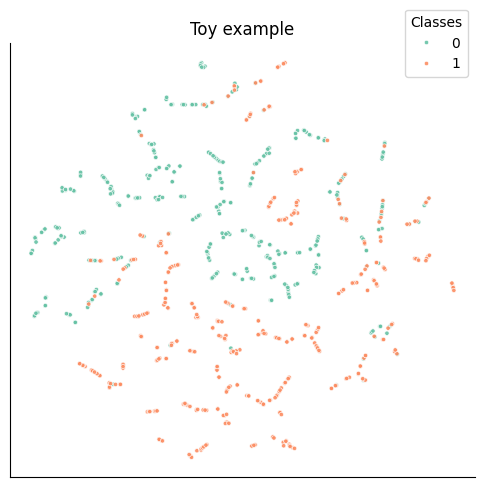

In [ ]:
def plot_embs(data,labels,emb_method="tsne"):
    precomputed_emb= None
    precomputed_emb = plot_emb(data,precomputed_emb=precomputed_emb,method=emb_method,colors=labels, legend="Side",title=f"Toy example",verbose=True,cmap="Set2",
                   annotation=None,s=10)
       

plot_embs(D,flat_labels)

In [48]:
methods["nca"].get_mahalanobis_matrix()

array([[9.85031407, 0.02607956],
       [0.02607956, 0.07327278]])

In [52]:
from metric_learn import LMNN, LFDA, MLKR, NCA

methods = {
    "nca": NCA(random_state=42,verbose=True),
    "lfda": LFDA(), #k=30
    "lmnn":LMNN(n_neighbors=30, learn_rate=1e-6,verbose=True,min_iter=10),
    
    
}

for m in methods:
    methods[m].fit(flat_dists,flat_labels)
    print(m)
    print(methods[m].get_mahalanobis_matrix())



Finding most discriminative components... 
done in  0.00s
[NCA]
[NCA]  Iteration      Objective Value    Time(s)
[NCA] ------------------------------------------
[NCA]          0         3.887052e+03       3.30


Text(0.5, 1.0, 'Learned Transformation')

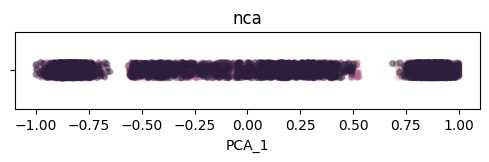

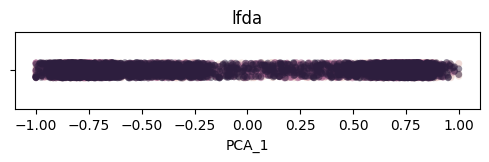

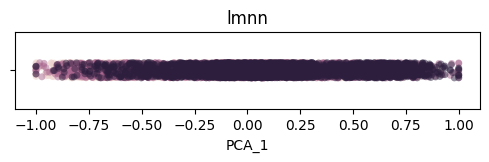

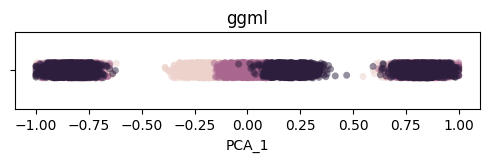

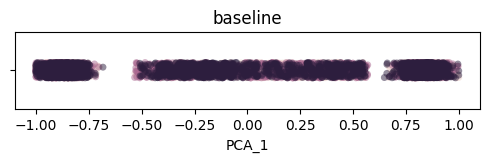

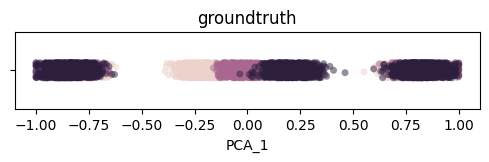

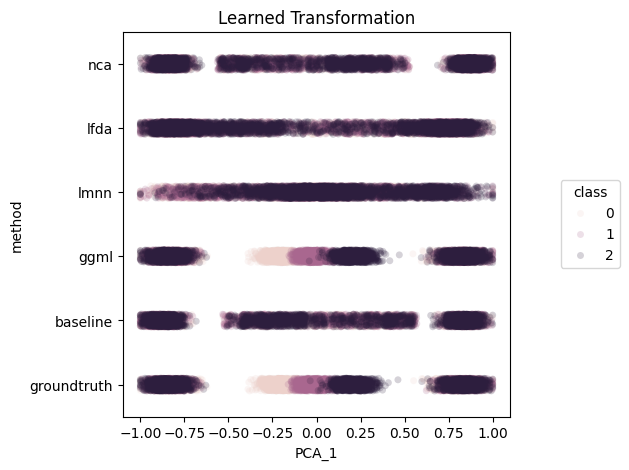

In [46]:
W = np.asarray([[ 1.8472049,     -0.00021469838],
 [ 0.0009644788,  -0.000732885  ]])

methods["ggml"]= lambda d: np.dot(W,d.transpose()).transpose()

methods["baseline"] = lambda d: d

W_star = np.asarray([[1,   0],
        [0,   0]])
methods["groundtruth"]= lambda d: np.dot(W_star,d.transpose()).transpose()

from sklearn.decomposition import PCA

def projection_plot(dists,labels,p,do_pca=True,title=""):
    i=0
    dfList_projected = []
    if do_pca:
        flat_dists = p(np.concatenate(dists))
        pca = PCA(n_components=1, svd_solver='full')
        pca.fit(flat_dists)

    for dist, l in zip(dists,labels):
        stacked_projected = p(dist) 
        if do_pca:
            stacked_projected = pca.transform(stacked_projected)
            stacked_projected = stacked_projected /np.max(np.abs(stacked_projected))
            dfList_projected.append(pd.DataFrame({'PCA_1':stacked_projected[:,0],'class':l,'dist':i % 4,'method':title})) #TODO ahrdcoded
        else:    
            dfList_projected.append(pd.DataFrame({'x':stacked_projected[:,0],'y':stacked_projected[:,1],'class':l,'dist':i % 4,'method':title})) #TODO ahrdcoded
        i += 1

    df_projected= pd.concat(dfList_projected, axis=0)
    plt.figure(figsize=(6,1))
    if do_pca:
        ax = sns.stripplot(df_projected, x="PCA_1",hue="class",alpha=0.5)
    else:
        ax = sns.scatterplot(df_projected,x='x',y='y',hue="class",style='dist',alpha=0.1)
    
    #ax.set_ylim(-0.01, 0.01)

    sns.move_legend(ax, "center right", bbox_to_anchor=(1.3, 0.5))
    ax.get_legend().remove()

    ax.set_title(title)

    return dfList_projected

dfs = {}

for m in methods:
    if m == "ggml" or m == "baseline" or m == "groundtruth":
        dfs[m]=projection_plot(dists,labels,methods[m],title=m)
    else:
        try:
            dfs[m]=projection_plot(dists,labels,lambda d: methods[m].transform(d),title=m)
        except:
            print(f"{m} failed")
dfs= pd.concat(sum(dfs.values(),[]), axis=(0))
plt.figure(figsize=(5,5))
ax = sns.stripplot(dfs, x="PCA_1", y="method",hue="class",alpha=0.2)
sns.move_legend(ax, "center right", bbox_to_anchor=(1.3, 0.5))
ax.set_title("Learned Transformation")

In [13]:
def plot_table(df,tranpose=False):
    format_df = df
    format_df.set_index('method',inplace=True)
    if tranpose:
        format_df = format_df.transpose()
    display(format_df)
    print(format_df.to_latex(index=True,
                  #formatters={"name": str.upper},
                  float_format="{:.2f}".format,
    ))
    

In [ ]:
import sklearn 
import scipy as sp
from ggml.benchmark import knn_from_dists

def compute_dist_matrix(X,d):
    D = np.zeros((len(X),len(X)))
    for i,x in enumerate(X):
        for j,y in enumerate(X):
            if i<=j:
                D[i,j] = d(x,y)
            else:
                D[i,j] = D[j,i]
    return D

results = {"method":[],
           #"KNN T=0.75":[],
           "KNN T=0.25":[],
           "ARI":[],
           #"VarInf":[],
           
           #"Time":[]}
}
fig, axs = plt.subplots(1,len(methods.keys()),figsize=(len(methods.keys())*5,5),squeeze=False)

for m, (method, trained_metric) in enumerate(methods.items()):
    if method=="ggml" or m == "baseline" or m == "groundtruth":
        #d = trained_metric
        if m == "baseline" or m == "groundtruth":
            continue
        theta = np.asarray([[-20.6616, 0],[0, 0.0407]])
        d= lambda x,y: np.linalg.norm(np.squeeze(np.dot(theta,x))-np.squeeze((np.dot(theta,y)))) 
    else:
        d = trained_metric.get_metric()

    D = compute_dist_matrix(flat_dists,d)

    print(D.shape)

    pred, true, score, _ = knn_from_dists(D,flat_labels,method=method,weights=None,test_size=0.5,n_splits=20,n_neighbors=5) #'distance'
    #for i,(p,t) in enumerate(zip(pred,true)):
    #plot_1split(np.concatenate(pred),np.concatenate(true),title=f"{method} Distance KNN {len(pred)}-Splits",ax=axs[0,m])

    #pred2, true2, score2, ari = KNN_from_dists(graphs,labels,method=method,precomputed_dists=precomputed_dists[method],weights='distance',test_size=0.9)
    #for i,(p,t) in enumerate(zip(pred,true)):
    #plot_1split(np.concatenate(pred2),np.concatenate(true2),title=f"{method} Distance KNN {len(pred2)}-Splits",ax=axs[1,m])

    #zero_dia_dists = precomputed_dists[method]
    #np.fill_diagonal(zero_dia_dists,0)
    #sil = silhouette_score(zero_dia_dists,labels,metric="precomputed")

    #ari = adjusted_rand_score(np.concatenate(true),np.concatenate(pred))
    
    pred_cluster = sklearn.cluster.AgglomerativeClustering(n_clusters=len(np.unique(flat_labels)),metric='precomputed',linkage='average').fit_predict(D)
    ari = sklearn.metrics.adjusted_rand_score(flat_labels,pred_cluster)
    print(ari)

    link = sp.cluster.hierarchy.linkage(sp.spatial.distance.squareform(D), method='average', optimal_ordering=True)
    pred_cluster = sp.cluster.hierarchy.fcluster(link,t=len(np.unique(flat_labels)),criterion="maxclust")
    ari = sklearn.metrics.adjusted_rand_score(flat_labels,pred_cluster)
    print(pred_cluster)


    #_ , grouped_labels = np_unique_indices(labels) #[np.where([labels==l]) for l in np.unique(labels)]
    #_ , grouped_clust = np_unique_indices(pred_cluster) #[np.where([pred_cluster==l]) for l in np.unique(pred_cluster)]
    #print(grouped_labels)
    #print(grouped_clust)
    #truth = NodeClustering(grouped_labels, graph=None, method_name="Pathological labels")
    #pred = NodeClustering(grouped_clust, graph=None, method_name="Predicted Cluster")
    #eval = cdlib.evaluation.variation_of_information(truth,pred)

    #plt.show()
    results["method"].append(method)
    #results["Classification Score"].append(np.average(score))
    #results["KNN T=0.75"].append(f"{np.average(score):.2f}±{np.std(score):.2f}")

    results["KNN T=0.25"].append(f"{np.average(score):.2f}±{np.std(score):.2f}")

    results["ARI"].append(f"{np.average(ari):.2f}")
    #results["VarInf"].append(eval[0])
    #results["SC"].append(("%.3f" % sil).replace("-0","-").lstrip("0")) 
    #results["Time"].append(f"{times[method]/(len(ccb_emb[0])*(len(ccb_emb[0])-1)/2) * 1000: .2f}")

fig.tight_layout()
plot_table(pd.DataFrame(results))

(3624, 3624)
-0.0005479732918060384
